# Caso: Modelo de Predicción de Default en Tarjetas de Crédito

Puede descargar los datos de: https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients#

### Instalar las librerías

In [1]:
! pip install kds

In [5]:
pip install missingno

Note: you may need to restart the kernel to use updated packages.


### **1. Carga de Modulos**

In [8]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
from matplotlib.legend_handler import HandlerBase
import seaborn as sns
import missingno as msno

%matplotlib inline  
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import train_test_split,cross_validate
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import confusion_matrix,accuracy_score,precision_score,recall_score,f1_score,RocCurveDisplay  # for classification

import kds

### **2. Lectura Inicial de base de datos**

#### 2.1. Carga de datos

In [9]:
# Leemos la data de desarrollo de modelos
df = pd.read_csv("../data/raw/defaultcc.csv").set_index('ID')

In [10]:
# Vemos la dimensionalidad
df.shape

(30000, 24)

In [11]:
# Visualizacion Global de los datos
df.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT
ID,,,,,,,,,,,,,,,,,,,,,
1,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
2,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
4,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
5,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


#### 2.2. Buenas prácticas

In [12]:
df.columns

Index(['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_1', 'PAY_2',
       'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'DEFAULT'],
      dtype='object')

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30000 entries, 1 to 30000
Data columns (total 24 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   LIMIT_BAL  30000 non-null  int64
 1   SEX        30000 non-null  int64
 2   EDUCATION  30000 non-null  int64
 3   MARRIAGE   30000 non-null  int64
 4   AGE        30000 non-null  int64
 5   PAY_1      30000 non-null  int64
 6   PAY_2      30000 non-null  int64
 7   PAY_3      30000 non-null  int64
 8   PAY_4      30000 non-null  int64
 9   PAY_5      30000 non-null  int64
 10  PAY_6      30000 non-null  int64
 11  BILL_AMT1  30000 non-null  int64
 12  BILL_AMT2  30000 non-null  int64
 13  BILL_AMT3  30000 non-null  int64
 14  BILL_AMT4  30000 non-null  int64
 15  BILL_AMT5  30000 non-null  int64
 16  BILL_AMT6  30000 non-null  int64
 17  PAY_AMT1   30000 non-null  int64
 18  PAY_AMT2   30000 non-null  int64
 19  PAY_AMT3   30000 non-null  int64
 20  PAY_AMT4   30000 non-null  int64
 21  PAY_AMT5   30000 

#### 3. AED

#### 3.1. Completitud de los datos

In [14]:
# Revisamos los valores nulos o missings!
df.isnull().sum()

LIMIT_BAL    0
SEX          0
EDUCATION    0
MARRIAGE     0
AGE          0
PAY_1        0
PAY_2        0
PAY_3        0
PAY_4        0
PAY_5        0
PAY_6        0
BILL_AMT1    0
BILL_AMT2    0
BILL_AMT3    0
BILL_AMT4    0
BILL_AMT5    0
BILL_AMT6    0
PAY_AMT1     0
PAY_AMT2     0
PAY_AMT3     0
PAY_AMT4     0
PAY_AMT5     0
PAY_AMT6     0
DEFAULT      0
dtype: int64

In [15]:
## Para variables Cualitativas
def plot_cat(feature):
  sns.countplot(data=df,x=feature)
  ax=sns.countplot(data=df,x=feature)

#### 3.2. Análisis Univariado

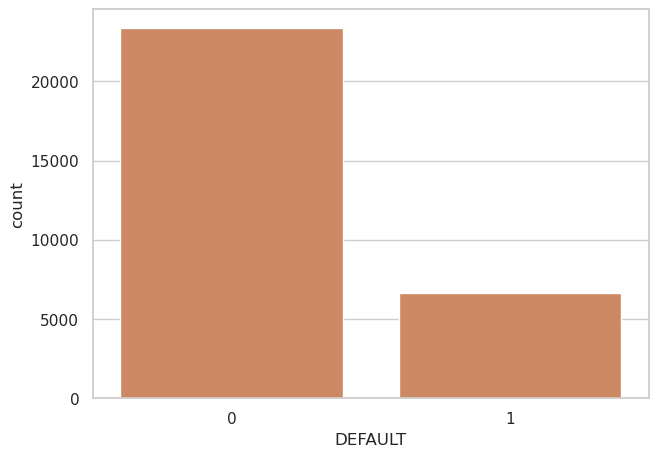

In [16]:
plot_cat('DEFAULT')

In [17]:
## Calculando la proporción del Target
df.DEFAULT.value_counts(normalize=True)

DEFAULT
0    0.7788
1    0.2212
Name: proportion, dtype: float64

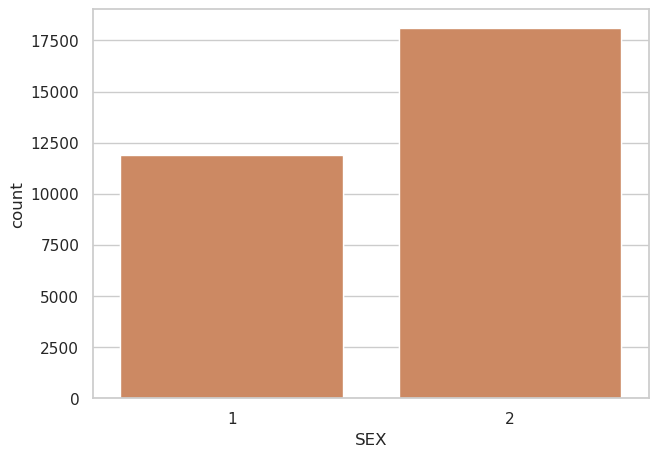

In [18]:
plot_cat('SEX')

In [19]:
df.groupby('SEX').DEFAULT.value_counts(normalize=True).unstack(fill_value=0)

DEFAULT,0,1
SEX,,
1,0.758328,0.241672
2,0.792237,0.207763


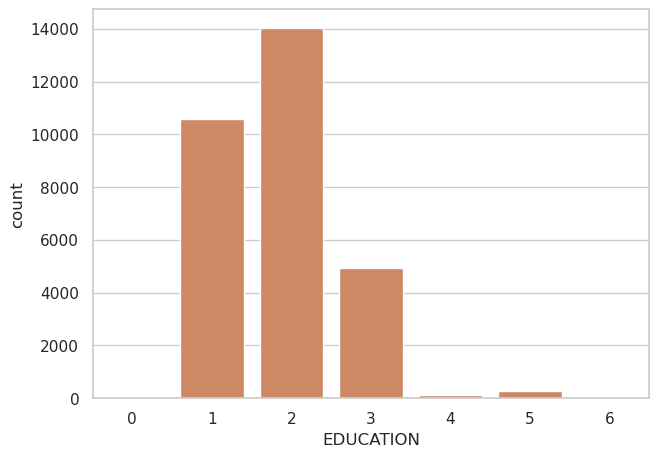

In [20]:
plot_cat('EDUCATION')

In [21]:
df.groupby('EDUCATION').DEFAULT.value_counts(normalize=True).unstack(fill_value=0)

DEFAULT,0,1
EDUCATION,,
0,1.000000,0.000000
1,0.807652,0.192348
2,0.762651,0.237349
3,0.748424,0.251576
4,0.943089,0.056911
5,0.935714,0.064286
6,0.843137,0.156863


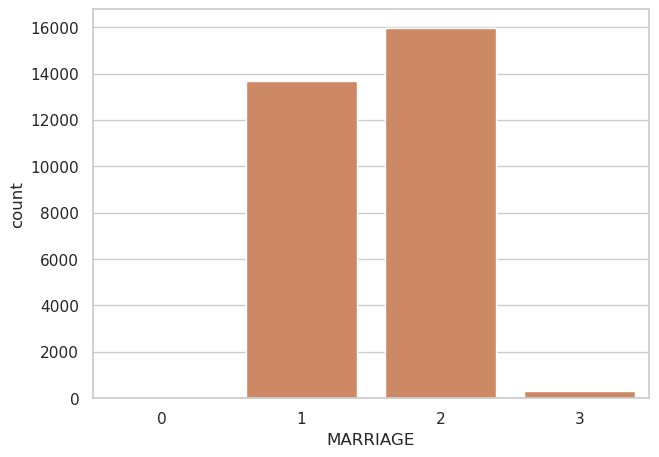

In [22]:
plot_cat('MARRIAGE')

In [23]:
df.groupby('MARRIAGE').DEFAULT.value_counts(normalize=True).unstack(fill_value=0)

DEFAULT,0,1
MARRIAGE,,
0,0.907407,0.092593
1,0.765283,0.234717
2,0.790717,0.209283
3,0.739938,0.260062


In [24]:
## Para variables cuantitativas
def plot_num(feature):
    fig,axes=plt.subplots(1,2)
    sns.boxplot(data=df,x=feature,ax=axes[0])
    sns.distplot(a=df[feature],ax=axes[1],color='#ff4125')
    fig.set_size_inches(15,5)

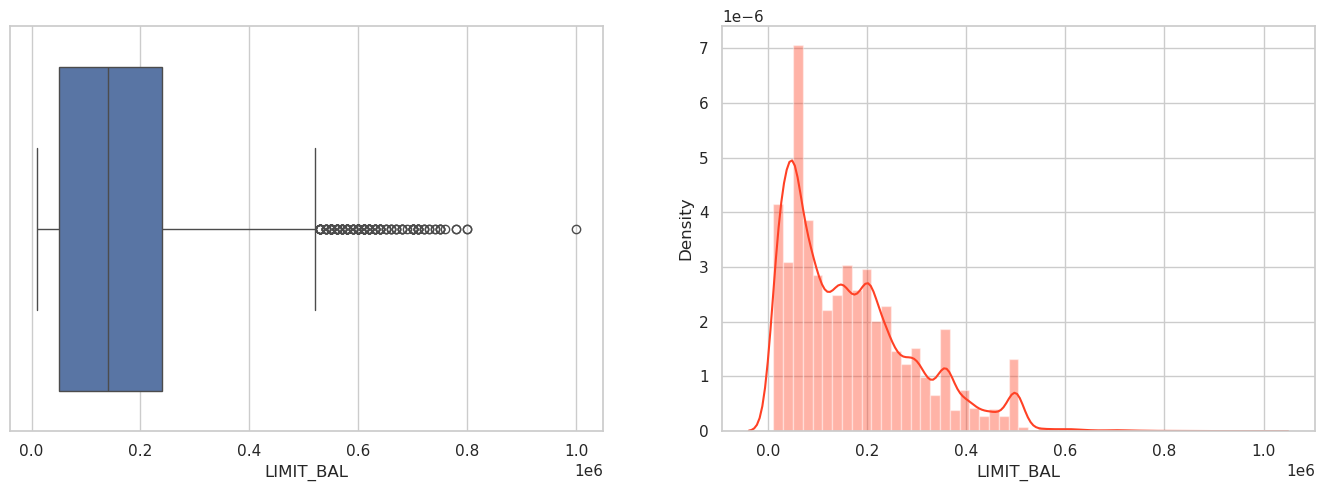

In [25]:
plot_num('LIMIT_BAL')

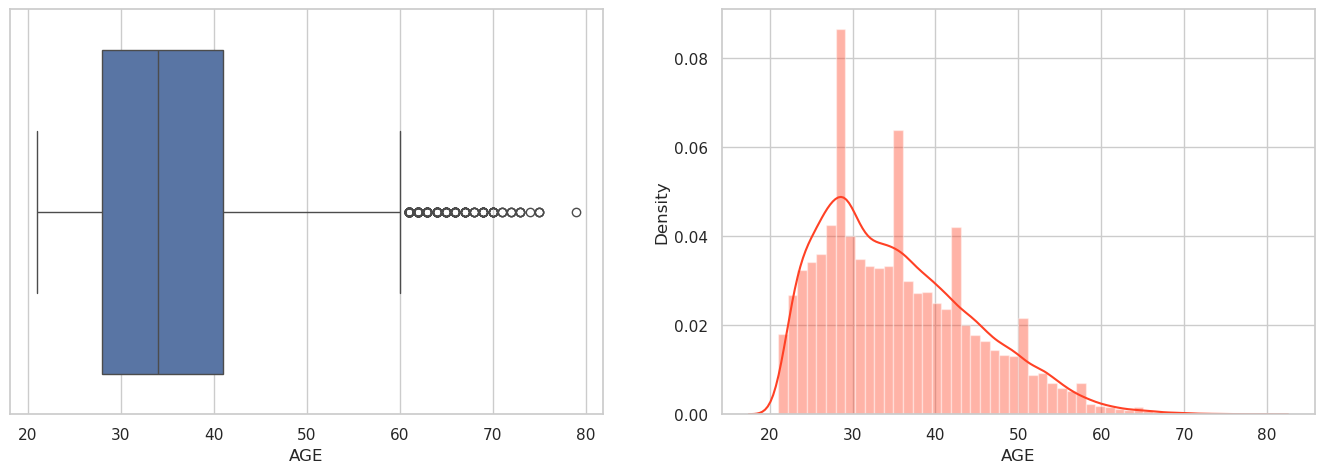

In [26]:
plot_num('AGE')

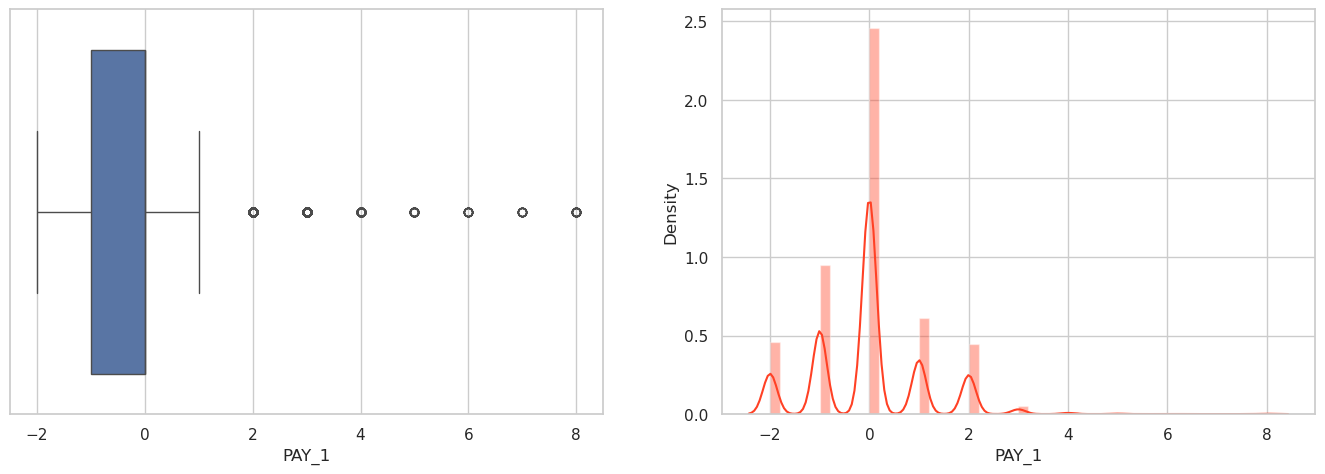

In [27]:
plot_num('PAY_1')

In [28]:
df.groupby('PAY_1').DEFAULT.value_counts(normalize=True).unstack(fill_value=0)

DEFAULT,0,1
PAY_1,,
-2,0.867706,0.132294
-1,0.832219,0.167781
0,0.871887,0.128113
1,0.660521,0.339479
2,0.308586,0.691414
3,0.242236,0.757764
4,0.315789,0.684211
5,0.500000,0.500000
6,0.454545,0.545455


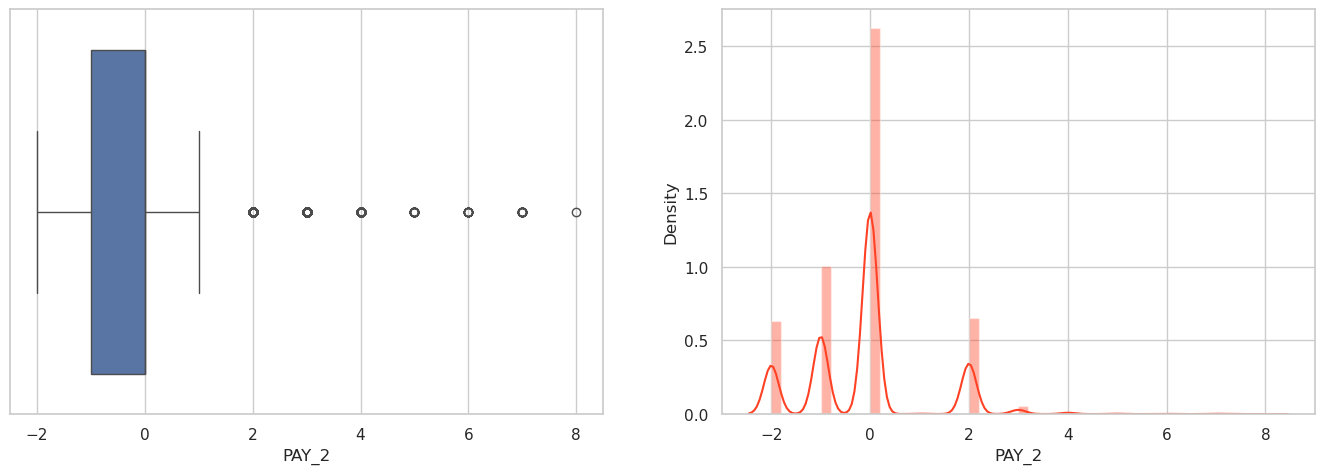

In [29]:
plot_num('PAY_2')

In [30]:
df.groupby('PAY_2').DEFAULT.value_counts(normalize=True).unstack(fill_value=0)

DEFAULT,0,1
PAY_2,,
-2,0.817292,0.182708
-1,0.840331,0.159669
0,0.840877,0.159123
1,0.821429,0.178571
2,0.443850,0.556150
3,0.383436,0.616564
4,0.494949,0.505051
5,0.400000,0.600000
6,0.250000,0.750000


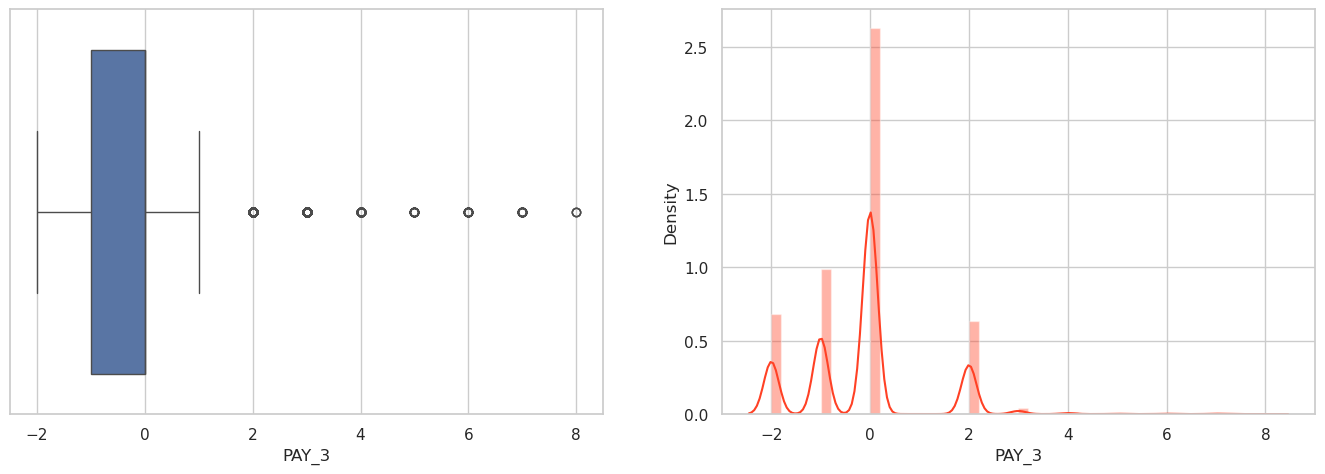

In [31]:
plot_num('PAY_3')

In [32]:
df.groupby('PAY_3').DEFAULT.value_counts(normalize=True).unstack(fill_value=0)

DEFAULT,0,1
PAY_3,,
-2,0.814688,0.185312
-1,0.844055,0.155945
0,0.825488,0.174512
1,0.750000,0.250000
2,0.484420,0.515580
3,0.425000,0.575000
4,0.421053,0.578947
5,0.428571,0.571429
6,0.391304,0.608696


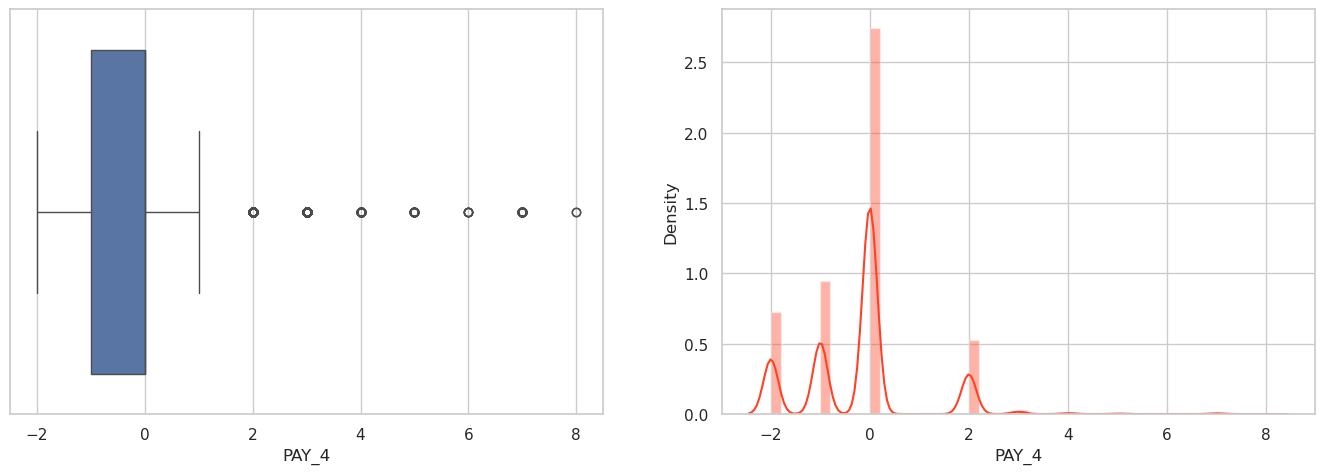

In [33]:
plot_num('PAY_4')

In [34]:
df.groupby('PAY_4').DEFAULT.value_counts(normalize=True).unstack(fill_value=0)

DEFAULT,0,1
PAY_4,,
-2,0.807498,0.192502
-1,0.841041,0.158959
0,0.816712,0.183288
1,0.500000,0.500000
2,0.476733,0.523267
3,0.388889,0.611111
4,0.333333,0.666667
5,0.485714,0.514286
6,0.600000,0.400000


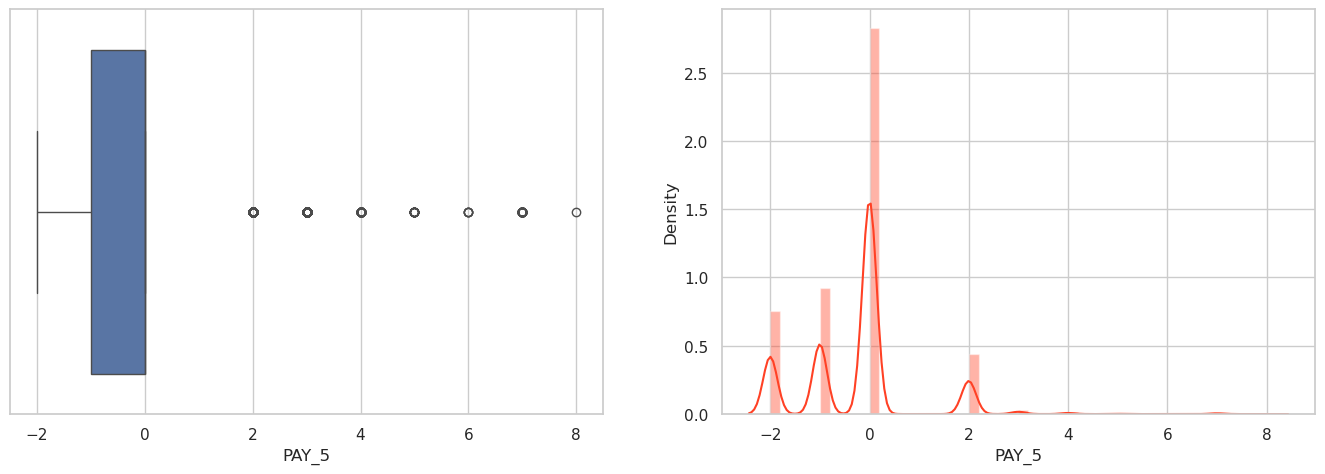

In [35]:
plot_num('PAY_5')

In [36]:
df.groupby('PAY_5').DEFAULT.value_counts(normalize=True).unstack(fill_value=0)

DEFAULT,0,1
PAY_5,,
-2,0.803124,0.196876
-1,0.838057,0.161943
0,0.811471,0.188529
2,0.458111,0.541889
3,0.365169,0.634831
4,0.392857,0.607143
5,0.411765,0.588235
6,0.250000,0.750000
7,0.172414,0.827586


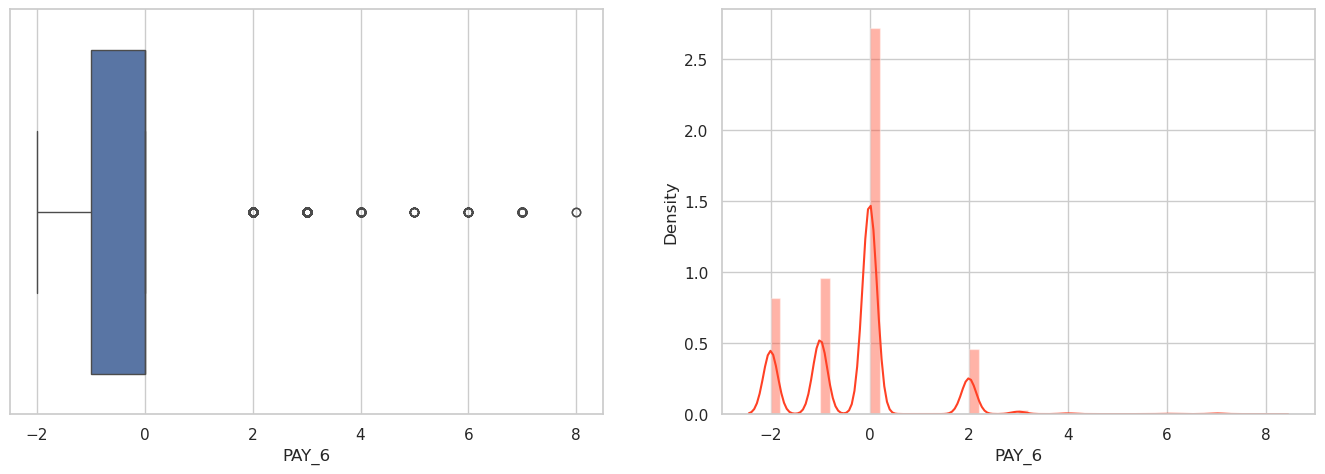

In [37]:
plot_num('PAY_6')

In [38]:
df.groupby('PAY_6').DEFAULT.value_counts(normalize=True).unstack(fill_value=0)

DEFAULT,0,1
PAY_6,,
-2,0.799591,0.200409
-1,0.830139,0.169861
0,0.811556,0.188444
2,0.493492,0.506508
3,0.358696,0.641304
4,0.367347,0.632653
5,0.461538,0.538462
6,0.263158,0.736842
7,0.173913,0.826087


<Axes: >

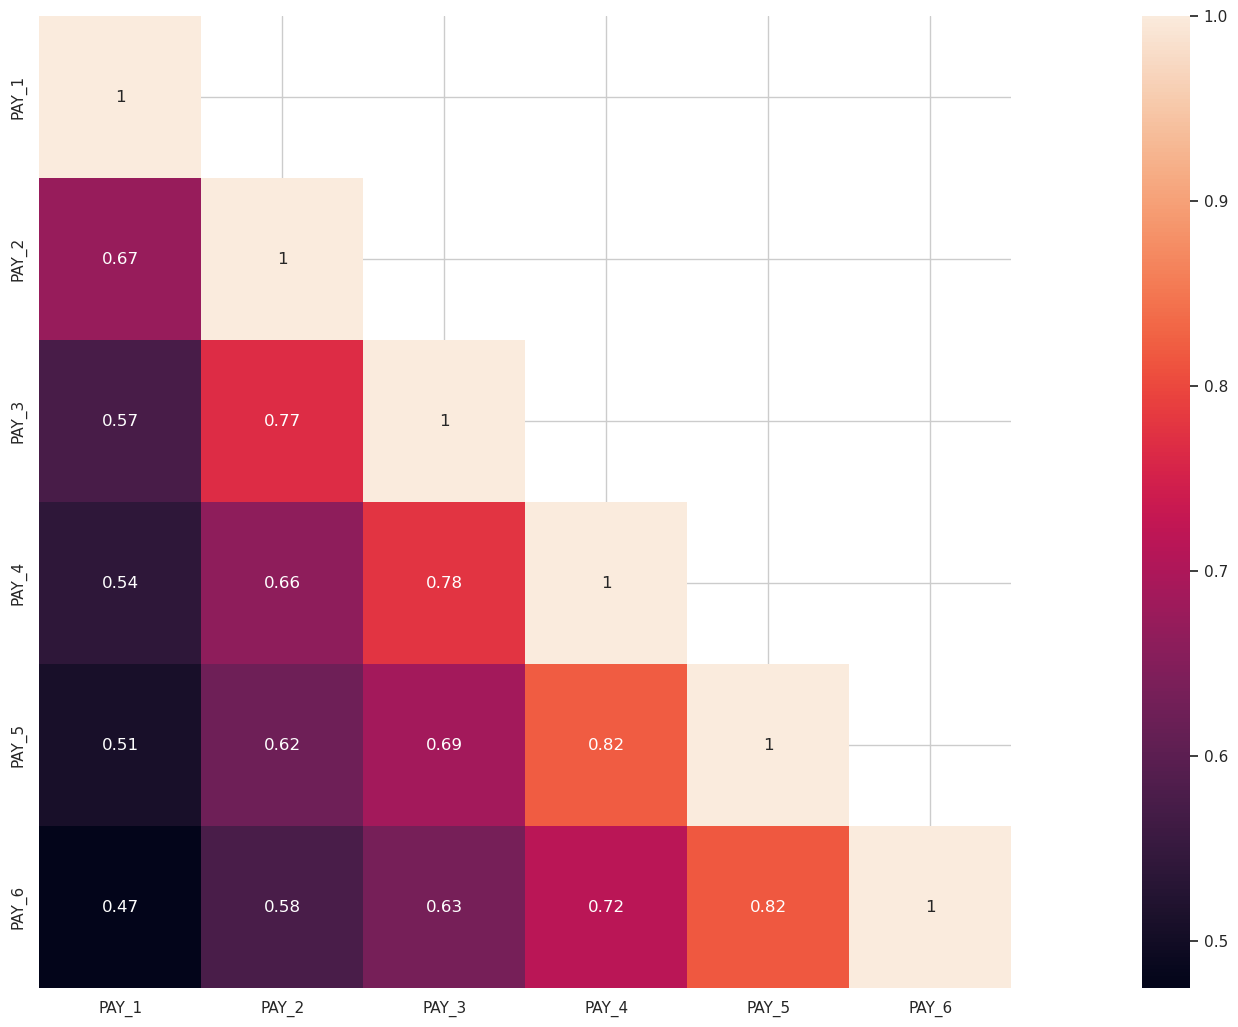

In [39]:
## Matriz de corelaciones
cor_mat = df[['PAY_1','PAY_2','PAY_3','PAY_4','PAY_5','PAY_6']].corr()
mask = np.array(cor_mat)
mask[np.tril_indices_from(mask)] = False
fig = plt.gcf()
fig.set_size_inches(30,12)
sns.heatmap(data=cor_mat,mask=mask,square=True,annot=True,cbar=True)

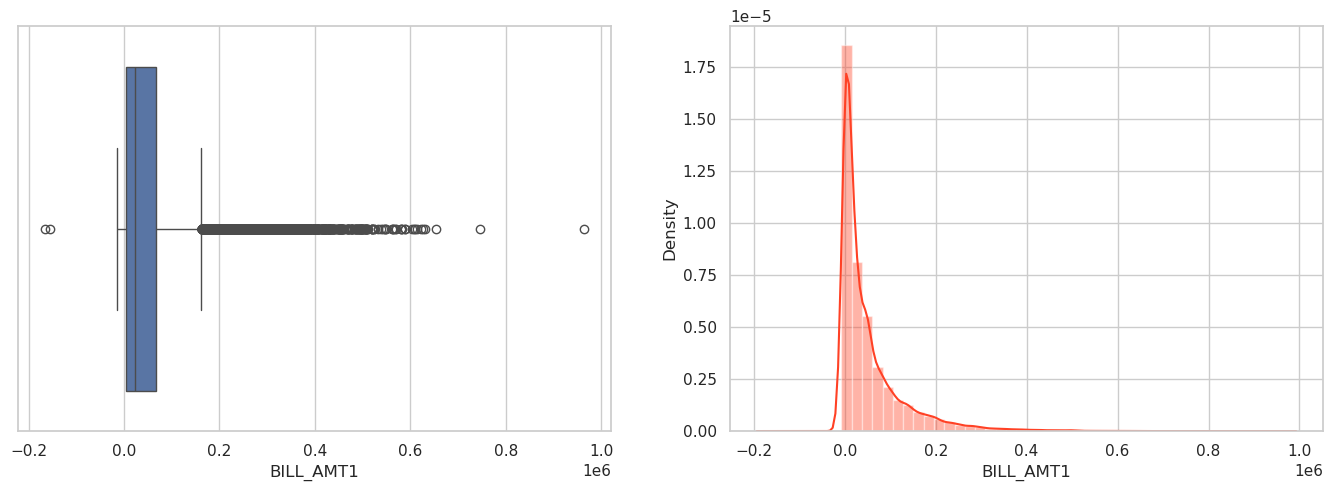

In [40]:
plot_num('BILL_AMT1')

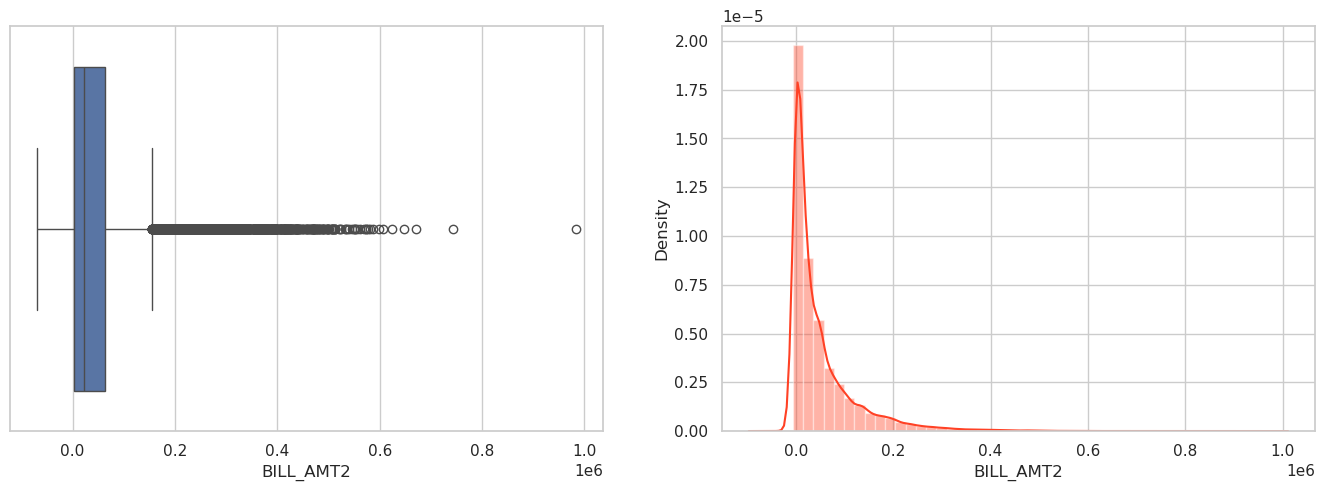

In [41]:
plot_num('BILL_AMT2')

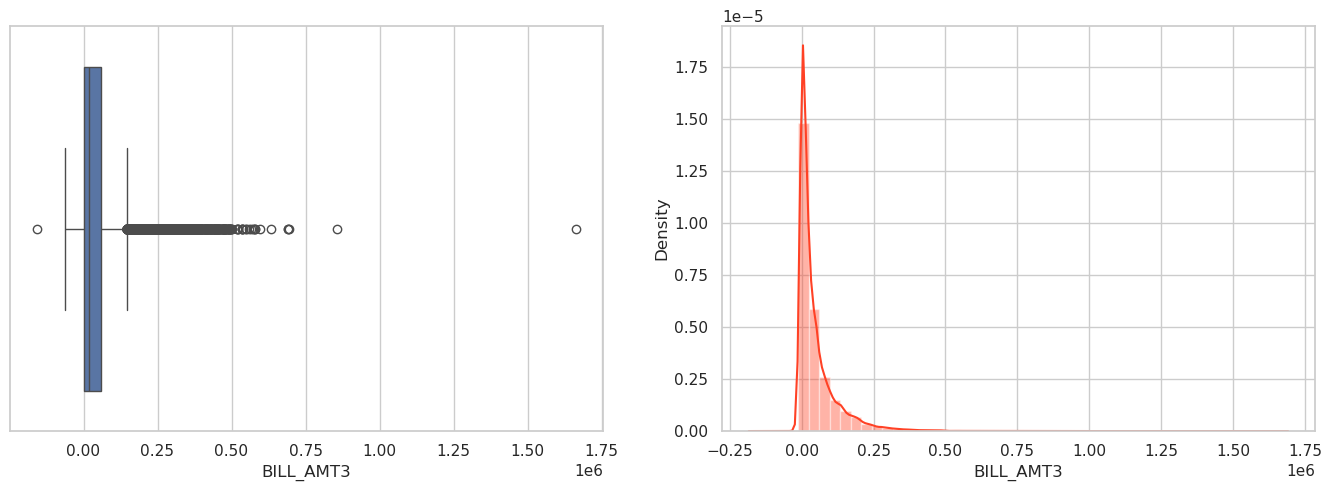

In [42]:
plot_num('BILL_AMT3')

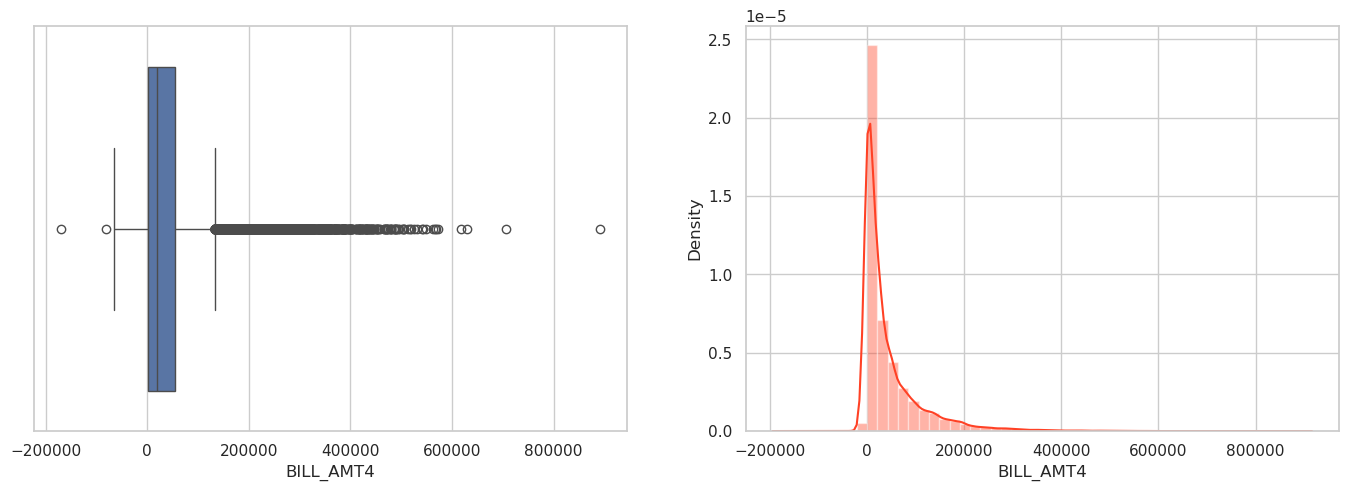

In [43]:
plot_num('BILL_AMT4')

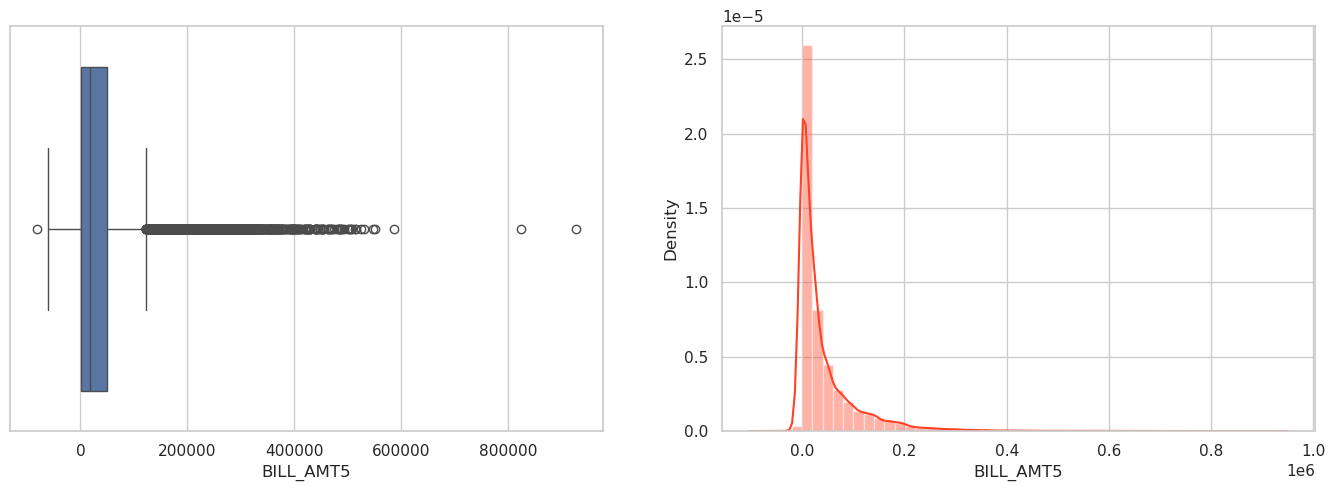

In [44]:
plot_num('BILL_AMT5')

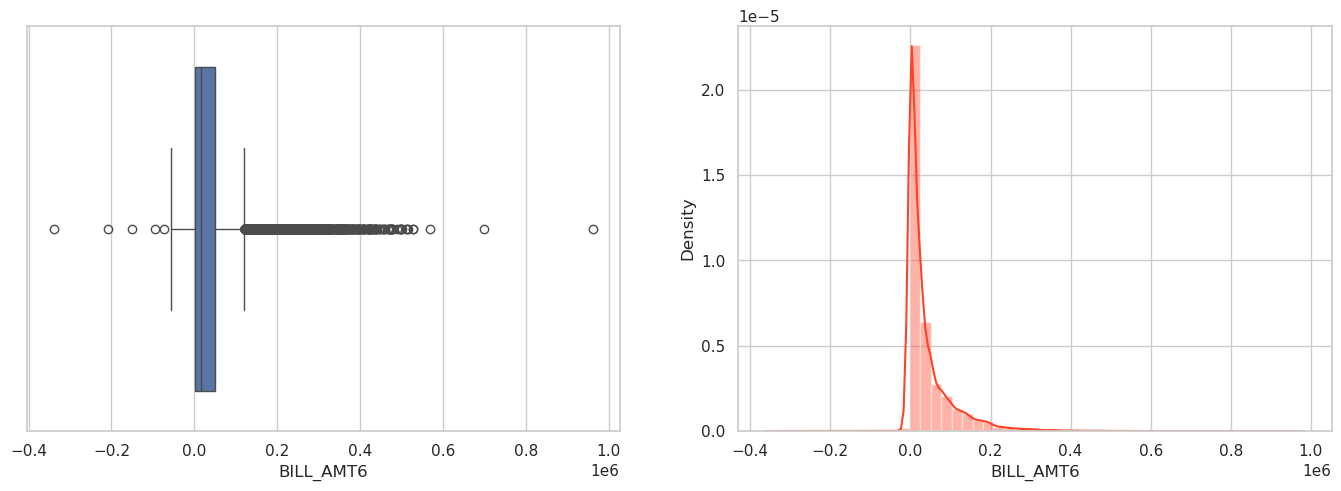

In [45]:
plot_num('BILL_AMT6')

<Axes: >

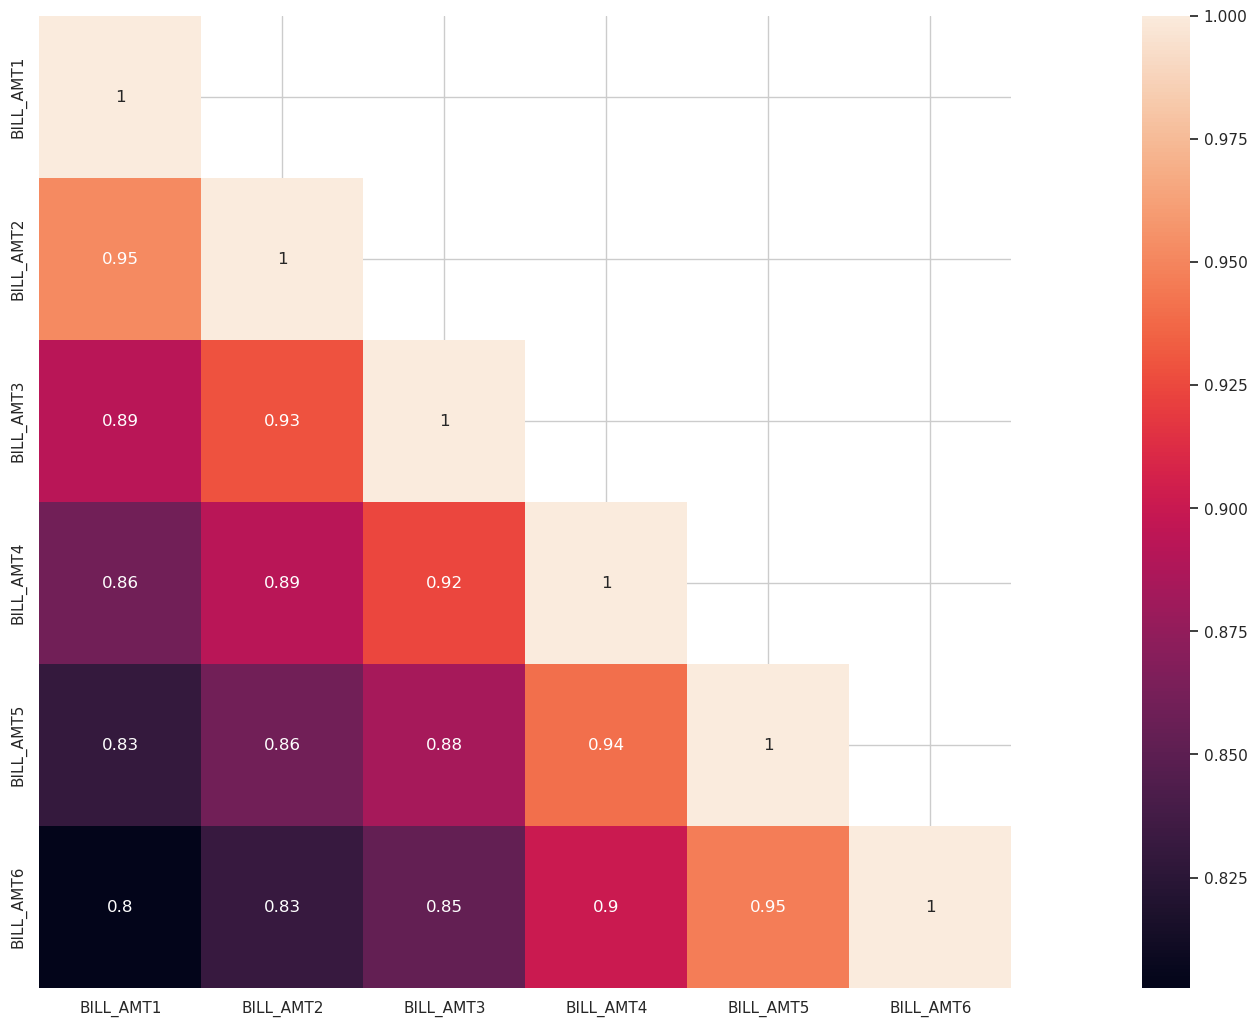

In [46]:
## Matriz de corelaciones
cor_mat = df[['BILL_AMT1','BILL_AMT2','BILL_AMT3','BILL_AMT4','BILL_AMT5','BILL_AMT6']].corr()
mask = np.array(cor_mat)
mask[np.tril_indices_from(mask)] = False
fig = plt.gcf()
fig.set_size_inches(30,12)
sns.heatmap(data=cor_mat,mask=mask,square=True,annot=True,cbar=True)

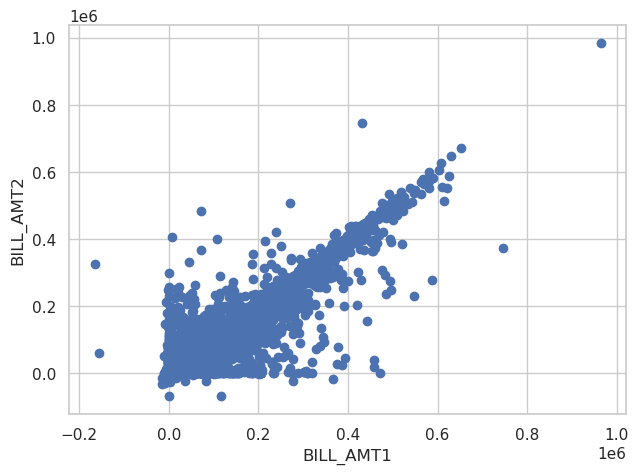

In [47]:
## Revisemos la correlación entre pares de variables
fig, ax = plt.subplots()
ax.scatter(x =(df['BILL_AMT1']), y = df['BILL_AMT2'])
plt.ylabel('BILL_AMT2')
plt.xlabel('BILL_AMT1')
plt.show()   

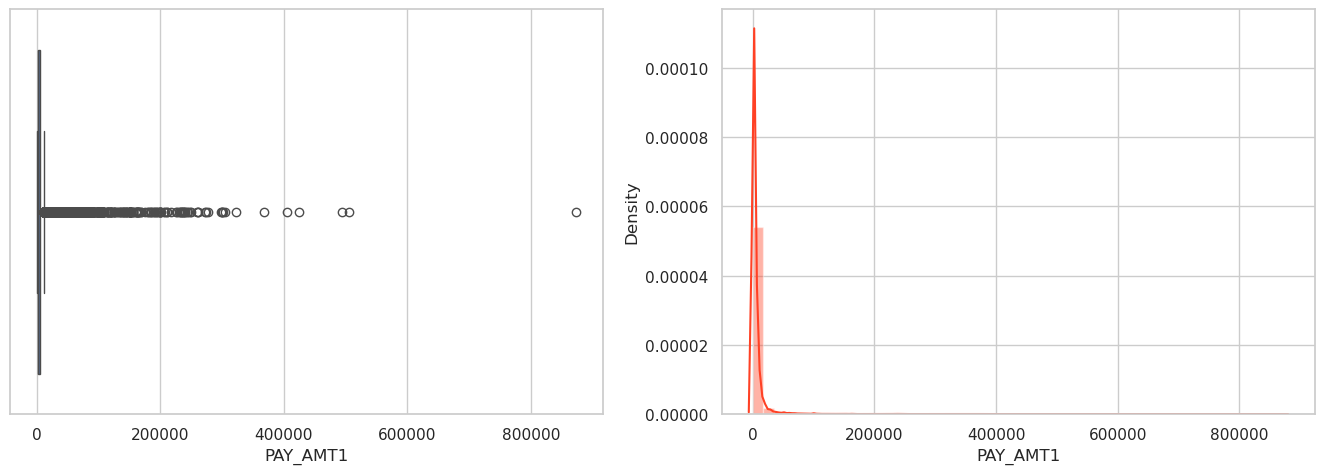

In [48]:
plot_num('PAY_AMT1')

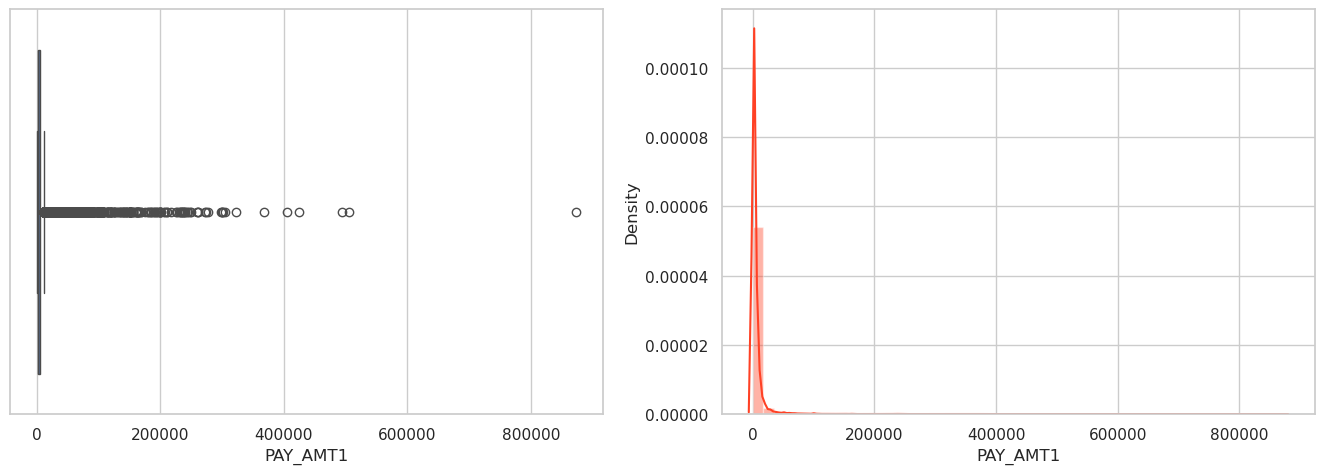

In [49]:
plot_num('PAY_AMT1')

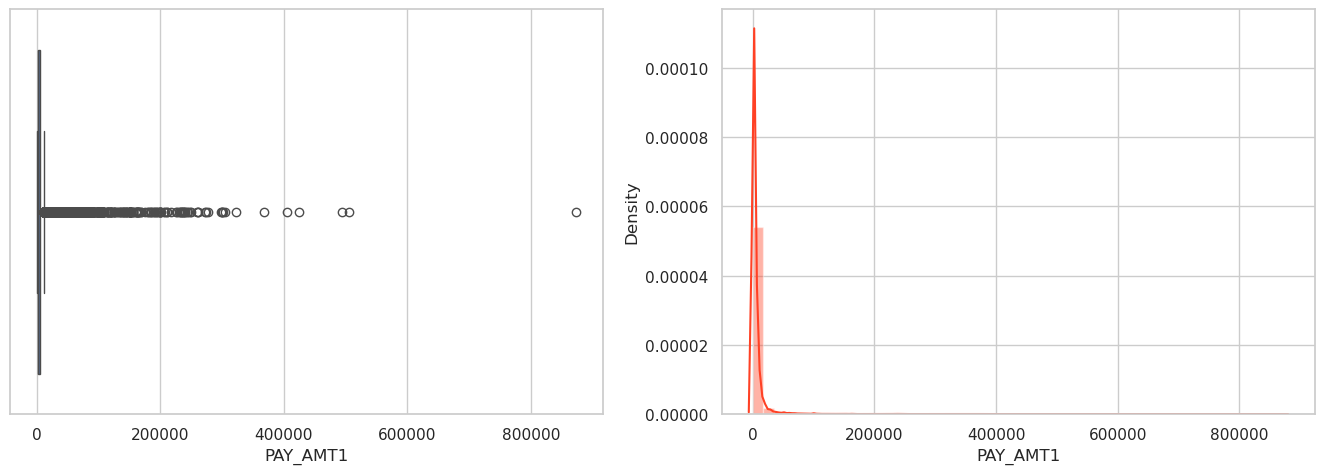

In [50]:
plot_num('PAY_AMT1')

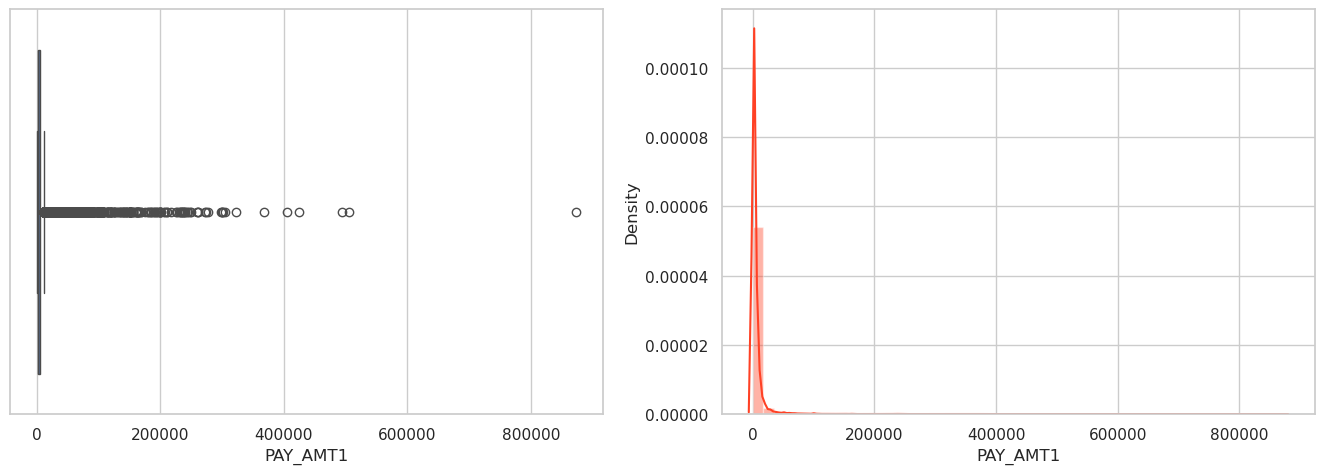

In [51]:
plot_num('PAY_AMT1')

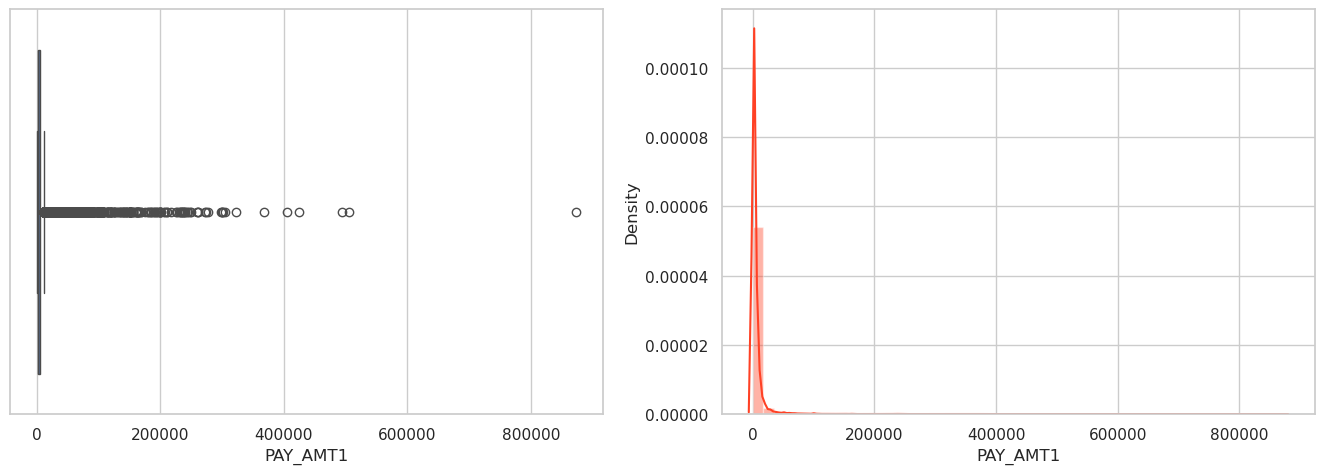

In [52]:
plot_num('PAY_AMT1')

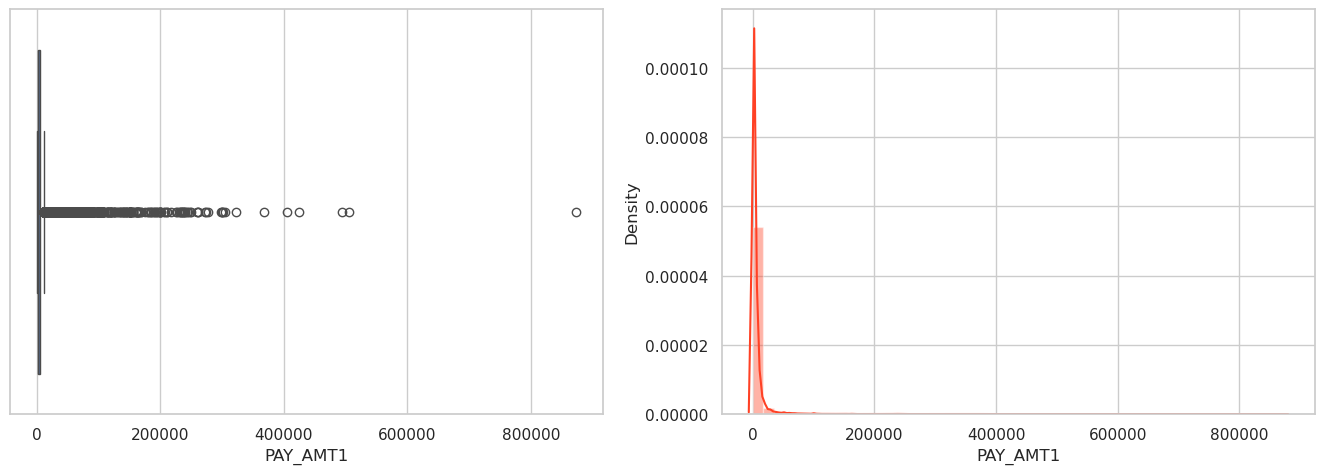

In [53]:
plot_num('PAY_AMT1')

<Axes: >

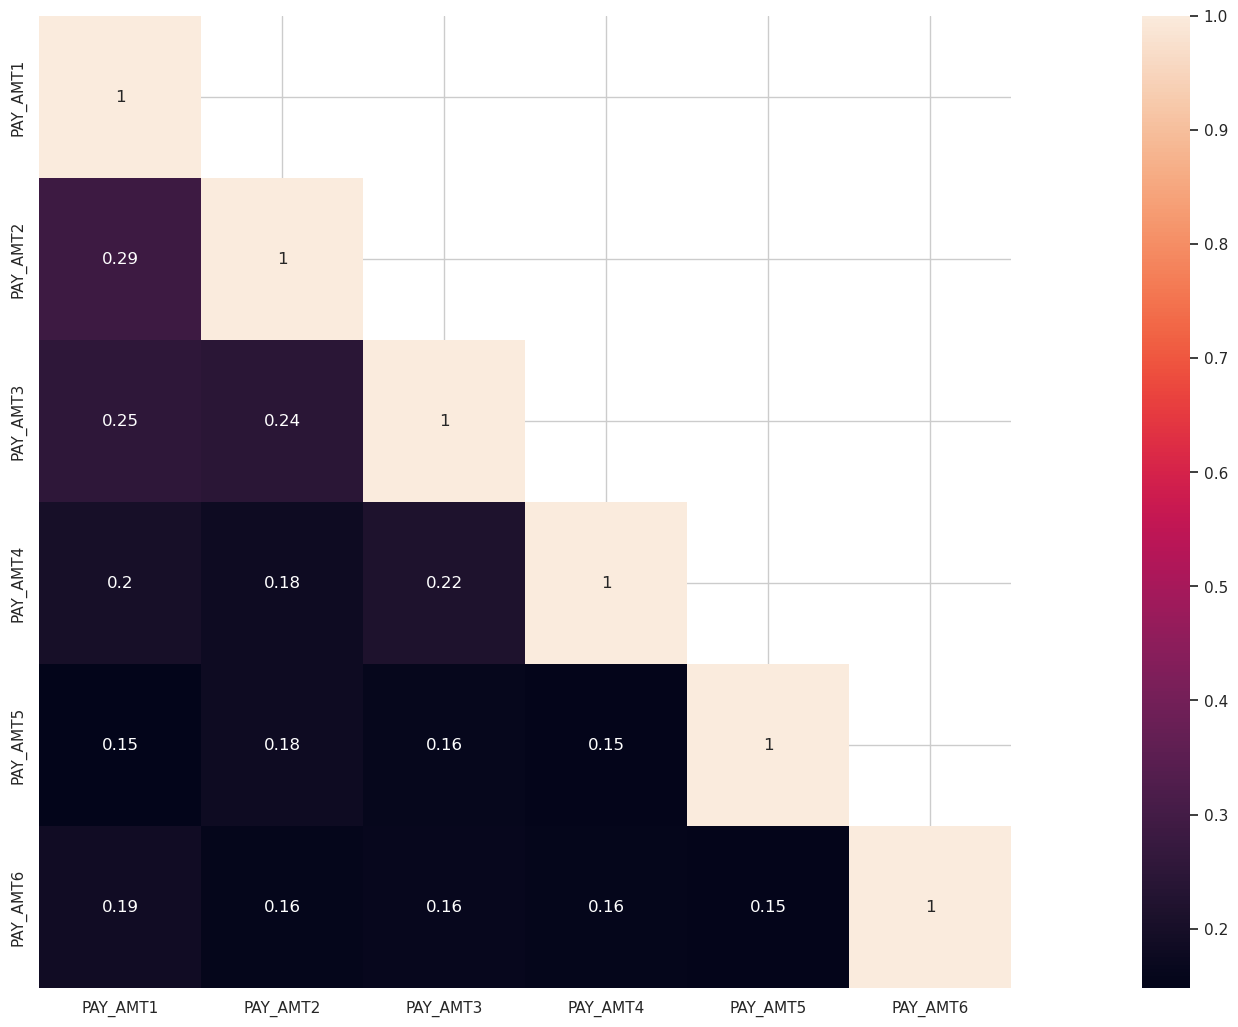

In [54]:
## Matriz de corelaciones
cor_mat = df[['PAY_AMT1','PAY_AMT2','PAY_AMT3','PAY_AMT4','PAY_AMT5','PAY_AMT6']].corr()
mask = np.array(cor_mat)
mask[np.tril_indices_from(mask)] = False
fig = plt.gcf()
fig.set_size_inches(30,12)
sns.heatmap(data=cor_mat,mask=mask,square=True,annot=True,cbar=True)

<Axes: >

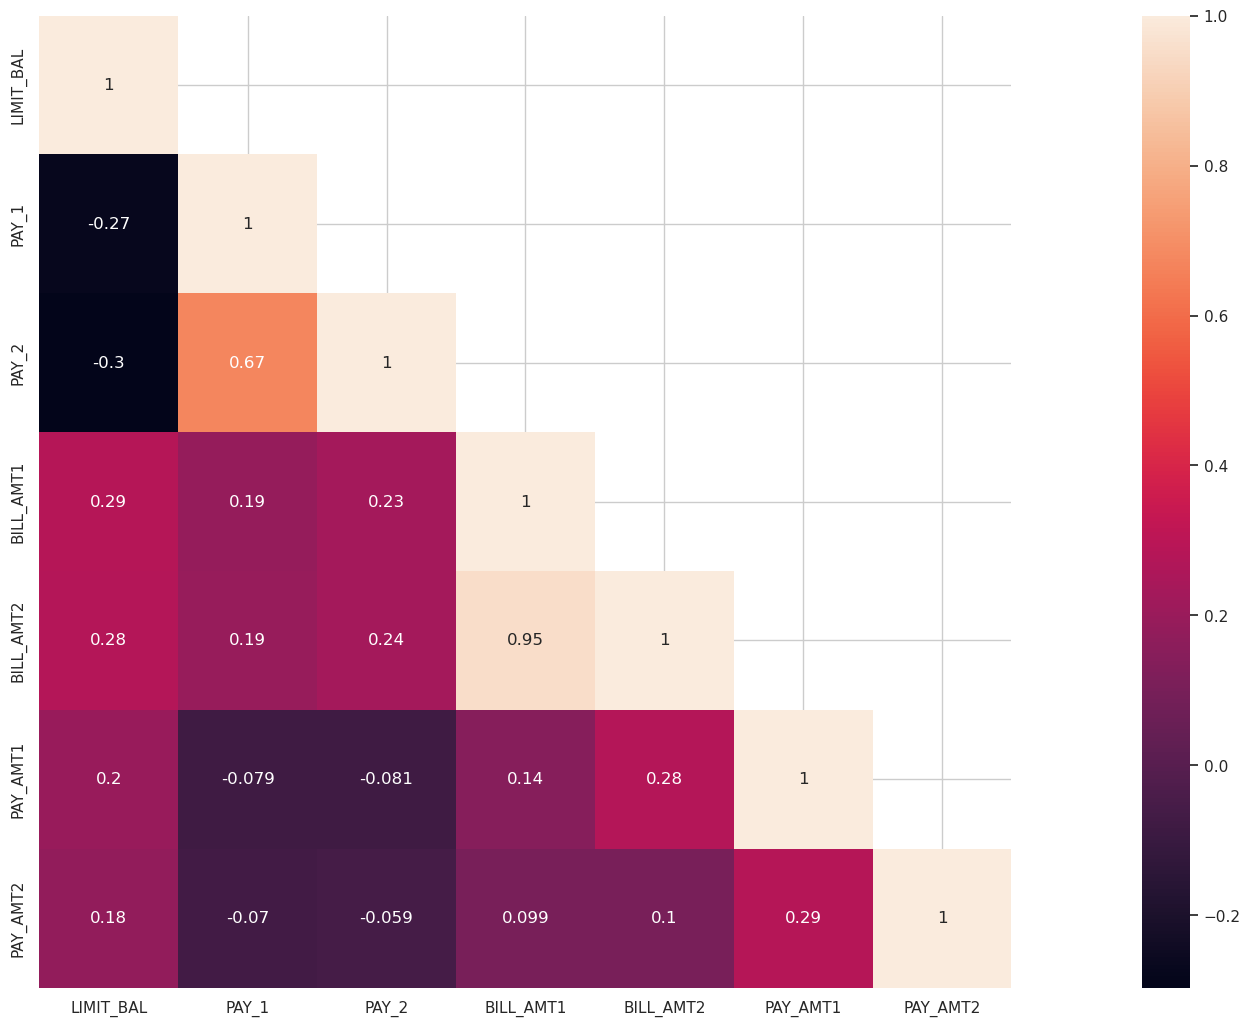

In [55]:
## Matriz de corelaciones
cor_mat = df[['LIMIT_BAL','PAY_1','PAY_2','BILL_AMT1','BILL_AMT2','PAY_AMT1','PAY_AMT2']].corr()
mask = np.array(cor_mat)
mask[np.tril_indices_from(mask)] = False
fig = plt.gcf()
fig.set_size_inches(30,12)
sns.heatmap(data=cor_mat,mask=mask,square=True,annot=True,cbar=True)

Observamos que no existen correlaciones significativas entre los tres grupos de variables

#### 3.2. Recodificacion y transformación de los datos

In [56]:
# Convertimos SEX en dummy
df.SEX=df.SEX-1

In [57]:
# Creamos tres Variables Dummy para EDUCATION
df['EDUCATION_1']=[1 if i == 1 else 0 for i in df['EDUCATION']]
df['EDUCATION_2']=[1 if i == 2 else 0 for i in df['EDUCATION']]
df['EDUCATION_3']=[1 if i == 3 else 0 for i in df['EDUCATION']]

In [58]:
# Creamos dos Variables Dummy para MARRIAGE
df['MARRIAGE_1']=[1 if i == 1 else 0 for i in df['MARRIAGE']]
df['MARRIAGE_2']=[1 if i == 2 else 0 for i in df['MARRIAGE']]

In [59]:
## Generar variables Cuantitativas transformadas
LIST_BILL = ['BILL_AMT1','BILL_AMT2','BILL_AMT3','BILL_AMT4','BILL_AMT5','BILL_AMT6']
for i in LIST_BILL:
 df.loc[df.loc[:,i]==-1,i]=0

In [60]:
df['LOG_BILL_AMT1'] = round(np.log1p(df['BILL_AMT1']),5)
df['LOG_BILL_AMT2'] = round(np.log1p(df['BILL_AMT2']),5)
df['LOG_BILL_AMT3'] = round(np.log1p(df['BILL_AMT3']),5)
df['LOG_BILL_AMT4'] = round(np.log1p(df['BILL_AMT4']),5)
df['LOG_BILL_AMT5'] = round(np.log1p(df['BILL_AMT5']),5)
df['LOG_BILL_AMT6'] = round(np.log1p(df['BILL_AMT6']),5)
df['LOG_PAY_AMT1'] = round(np.log1p(df['PAY_AMT1']),5)
df['LOG_PAY_AMT2'] = round(np.log1p(df['PAY_AMT2']),5)
df['LOG_PAY_AMT3'] = round(np.log1p(df['PAY_AMT3']),5)
df['LOG_PAY_AMT4'] = round(np.log1p(df['PAY_AMT4']),5)
df['LOG_PAY_AMT5'] = round(np.log1p(df['PAY_AMT5']),5)
df['LOG_PAY_AMT6'] = round(np.log1p(df['PAY_AMT6']),5)

In [61]:
LIST_PAY  = ['PAY_1','PAY_2','PAY_3','PAY_4','PAY_5','PAY_6']
LIST_BILL = ['LOG_BILL_AMT1','LOG_BILL_AMT2','LOG_BILL_AMT3','LOG_BILL_AMT4','LOG_BILL_AMT5','LOG_BILL_AMT6']
LIST_PAMT = ['LOG_PAY_AMT1','LOG_PAY_AMT2','LOG_PAY_AMT3','LOG_PAY_AMT4','LOG_PAY_AMT5','LOG_PAY_AMT6']

In [62]:
for i in LIST_BILL:
 df.loc[df.loc[:,i].isnull(),i]=0

### **4. Ingeniería y Selección de Variables**

#### 4.1. Ingenieria de variables

In [63]:
## Creamos las variables para el entrenamiento o train
df['SUM_PAY_TOT']    = df[LIST_PAY].sum(axis=1)
df['STD_PAY_TOT']    = df[LIST_PAY].std(axis=1)
df['SUM_PAY_REC']    = df['PAY_1'] + df['PAY_2']
df['CANT_PAY_MAY0']  = df[LIST_PAY].gt(0).sum(axis=1)
df['AVG_LBILL_TOT']  = df[LIST_BILL].mean(axis=1)
df['STD_LBILL_TOT']  = df[LIST_BILL].std(axis=1)
df['CV_LBILL_TOT']   =  df['STD_LBILL_TOT']/(df['AVG_LBILL_TOT']+1)
df['SUM_LBILL_REC']  = df['LOG_BILL_AMT1'] + df['LOG_BILL_AMT2']
df['CANT_LBILL_MAY0']= df[LIST_BILL].gt(0).sum(axis=1)
df['AVG_LPAY_TOT']   = df[LIST_PAMT].mean(axis=1)
df['STD_LPAY_TOT']   = df[LIST_PAMT].std(axis=1)
df['CV_LPAY_TOT']    =  df['STD_LPAY_TOT']/(df['AVG_LPAY_TOT']+1)
df['SUM_LPAY_REC']   = df['LOG_PAY_AMT1'] + df['LOG_PAY_AMT2']
df['CANT_LPAY_MAY0'] = df[LIST_PAMT].gt(0).sum(axis=1)
df['RATE_PAY_BILL1'] = df['PAY_AMT1']/(df['BILL_AMT1']+1)
df['RATE_PAY_BILL2'] = df['PAY_AMT2']/(df['BILL_AMT2']+1)
df['AVG_EXP_5'] = ((df['BILL_AMT5'] - (df['BILL_AMT6'] - df['PAY_AMT5']))) / df['LIMIT_BAL']
df['AVG_EXP_4'] = (((df['BILL_AMT5'] - (df['BILL_AMT6'] - df['PAY_AMT5'])) +
                 (df['BILL_AMT4'] - (df['BILL_AMT5'] - df['PAY_AMT4']))) / 2) / df['LIMIT_BAL']
df['AVG_EXP_3'] = (((df['BILL_AMT5'] - (df['BILL_AMT6'] - df['PAY_AMT5'])) +
                 (df['BILL_AMT4'] - (df['BILL_AMT5'] - df['PAY_AMT4'])) +
                 (df['BILL_AMT3'] - (df['BILL_AMT4'] - df['PAY_AMT3']))) / 3) / df['LIMIT_BAL']
df['AVG_EXP_2'] = (((df['BILL_AMT5'] - (df['BILL_AMT6'] - df['PAY_AMT5'])) +
                 (df['BILL_AMT4'] - (df['BILL_AMT5'] - df['PAY_AMT4'])) +
                 (df['BILL_AMT3'] - (df['BILL_AMT4'] - df['PAY_AMT3'])) +
                 (df['BILL_AMT2'] - (df['BILL_AMT3'] - df['PAY_AMT2']))) / 4) / df['LIMIT_BAL']
df['AVG_EXP_1'] = (((df['BILL_AMT5'] - (df['BILL_AMT6'] - df['PAY_AMT5'])) +
                 (df['BILL_AMT4'] - (df['BILL_AMT5'] - df['PAY_AMT4'])) +
                 (df['BILL_AMT3'] - (df['BILL_AMT4'] - df['PAY_AMT3'])) +
                 (df['BILL_AMT2'] - (df['BILL_AMT3'] - df['PAY_AMT2'])) +
                 (df['BILL_AMT1'] - (df['BILL_AMT2'] - df['PAY_AMT1']))) / 5) / df['LIMIT_BAL']

In [64]:
df.to_csv("../data/processed/credit_val.csv")

<Axes: >

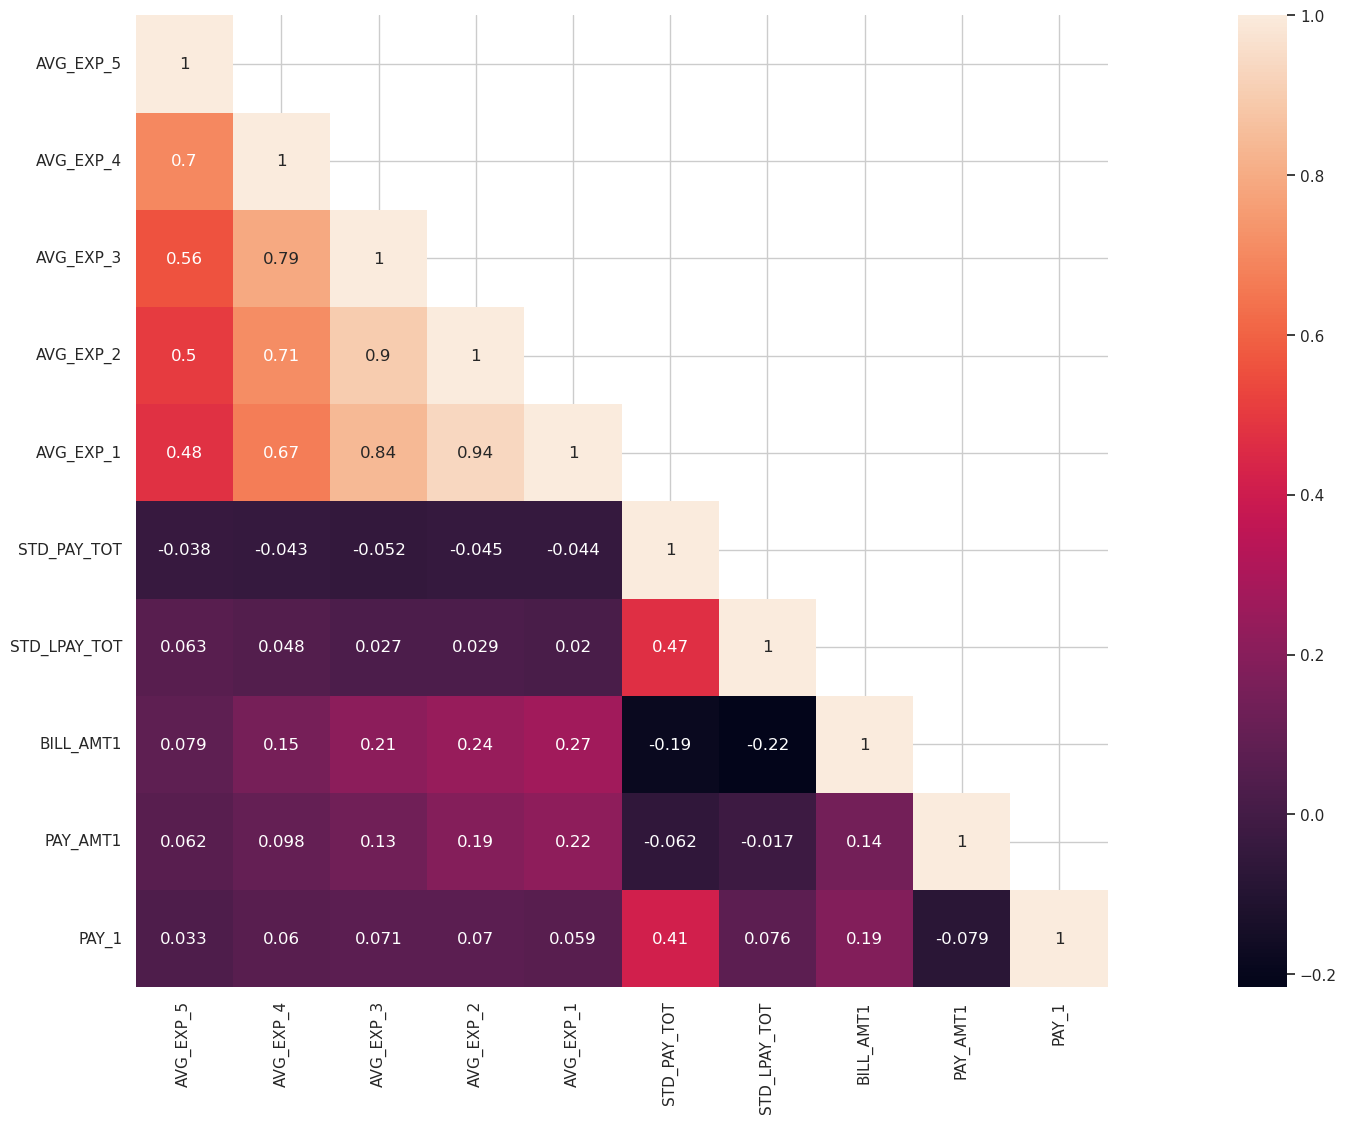

In [65]:
## Matriz de corelaciones
cor_mat = df[['AVG_EXP_5','AVG_EXP_4','AVG_EXP_3','AVG_EXP_2','AVG_EXP_1','STD_PAY_TOT','STD_LPAY_TOT','BILL_AMT1','PAY_AMT1','PAY_1']].corr()
mask = np.array(cor_mat)
mask[np.tril_indices_from(mask)] = False
fig = plt.gcf()
fig.set_size_inches(30,12)
sns.heatmap(data=cor_mat,mask=mask,square=True,annot=True,cbar=True)

In [66]:
df.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,...,CV_LPAY_TOT,SUM_LPAY_REC,CANT_LPAY_MAY0,RATE_PAY_BILL1,RATE_PAY_BILL2,AVG_EXP_5,AVG_EXP_4,AVG_EXP_3,AVG_EXP_2,AVG_EXP_1
ID,,,,,,,,,,,,,,,,,,,,,
1,20000,1,2,1,24,2,2,-1,-1,-2,...,1.277176,6.53669,1,0.000000,0.222043,0.000000,0.000000,0.011483,0.047387,0.046020
2,120000,1,2,2,26,-1,2,0,0,0,...,0.640925,6.90875,4,0.000000,0.579374,0.001617,0.004213,0.003947,0.003050,0.004035
3,90000,1,2,2,34,0,0,0,0,0,...,0.074941,14.63970,6,0.051915,0.106929,0.004433,0.004344,0.003741,0.008272,0.043796
4,50000,1,2,1,37,0,0,0,0,0,...,0.039165,15.21225,6,0.042561,0.041858,0.009620,0.009360,0.154087,0.120370,0.099324
5,50000,0,2,1,57,-1,0,-1,0,0,...,0.175054,18.11144,6,0.232072,6.468171,0.014080,0.114980,0.242620,0.214545,0.191424


In [67]:
df.shape

(30000, 62)

#### 4.1. Selección de variables

In [68]:
# Seleccion por Random Forest
forest = RandomForestClassifier(n_jobs=-1)
forest.fit(df.drop(['DEFAULT'],axis=1), df.DEFAULT)
importances = forest.feature_importances_

In [69]:
# Seleccion por Random Forest
TablaImportancia = pd.concat([pd.DataFrame({'Driver':list(df.drop(['DEFAULT'],axis=1).columns)}),
                              pd.DataFrame({'Importancia':list(forest.feature_importances_)})], axis = 1)
ImportanciaVariables = TablaImportancia[['Driver','Importancia']].sort_values('Importancia', ascending = False).reset_index(drop = True)
ImportanciaVariables.head(20)

,Driver,Importancia
0,SUM_PAY_REC,0.044179
1,PAY_1,0.041544
2,AGE,0.037354
3,LIMIT_BAL,0.032123
4,SUM_PAY_TOT,0.029421
5,CANT_PAY_MAY0,0.028733
6,STD_LBILL_TOT,0.024665
7,CV_LBILL_TOT,0.023994
8,AVG_LPAY_TOT,0.023401
9,AVG_EXP_1,0.023238


In [70]:
# Regresion Logistica
import statsmodels.api as sm
logit_model=sm.Logit(df.DEFAULT,df.drop(['DEFAULT'],axis=1))
result=logit_model.fit()
print(result.summary2())

         Current function value: 0.440284
         Iterations: 35


/opt/conda/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                             Results: Logit
Model:                 Logit              Method:             MLE       
Dependent Variable:    DEFAULT            Pseudo R-squared:   0.167     
Date:                  2024-05-29 00:45   AIC:                26527.0286
No. Observations:      30000              BIC:                26984.0210
Df Model:              54                 Log-Likelihood:     -13209.   
Df Residuals:          29945              LL-Null:            -15853.   
Converged:             0.0000             LLR p-value:        0.0000    
No. Iterations:        35.0000            Scale:              1.0000    
------------------------------------------------------------------------
                 Coef.   Std.Err.     z    P>|z|     [0.025     0.975]  
------------------------------------------------------------------------
LIMIT_BAL       -0.0000     0.0000 -8.6301 0.0000     -0.0000    -0.0000
SEX             -0.1136     0.0320 -3.5534 0.0004     -0.1763    -0.0510
EDUCATI

<Axes: >

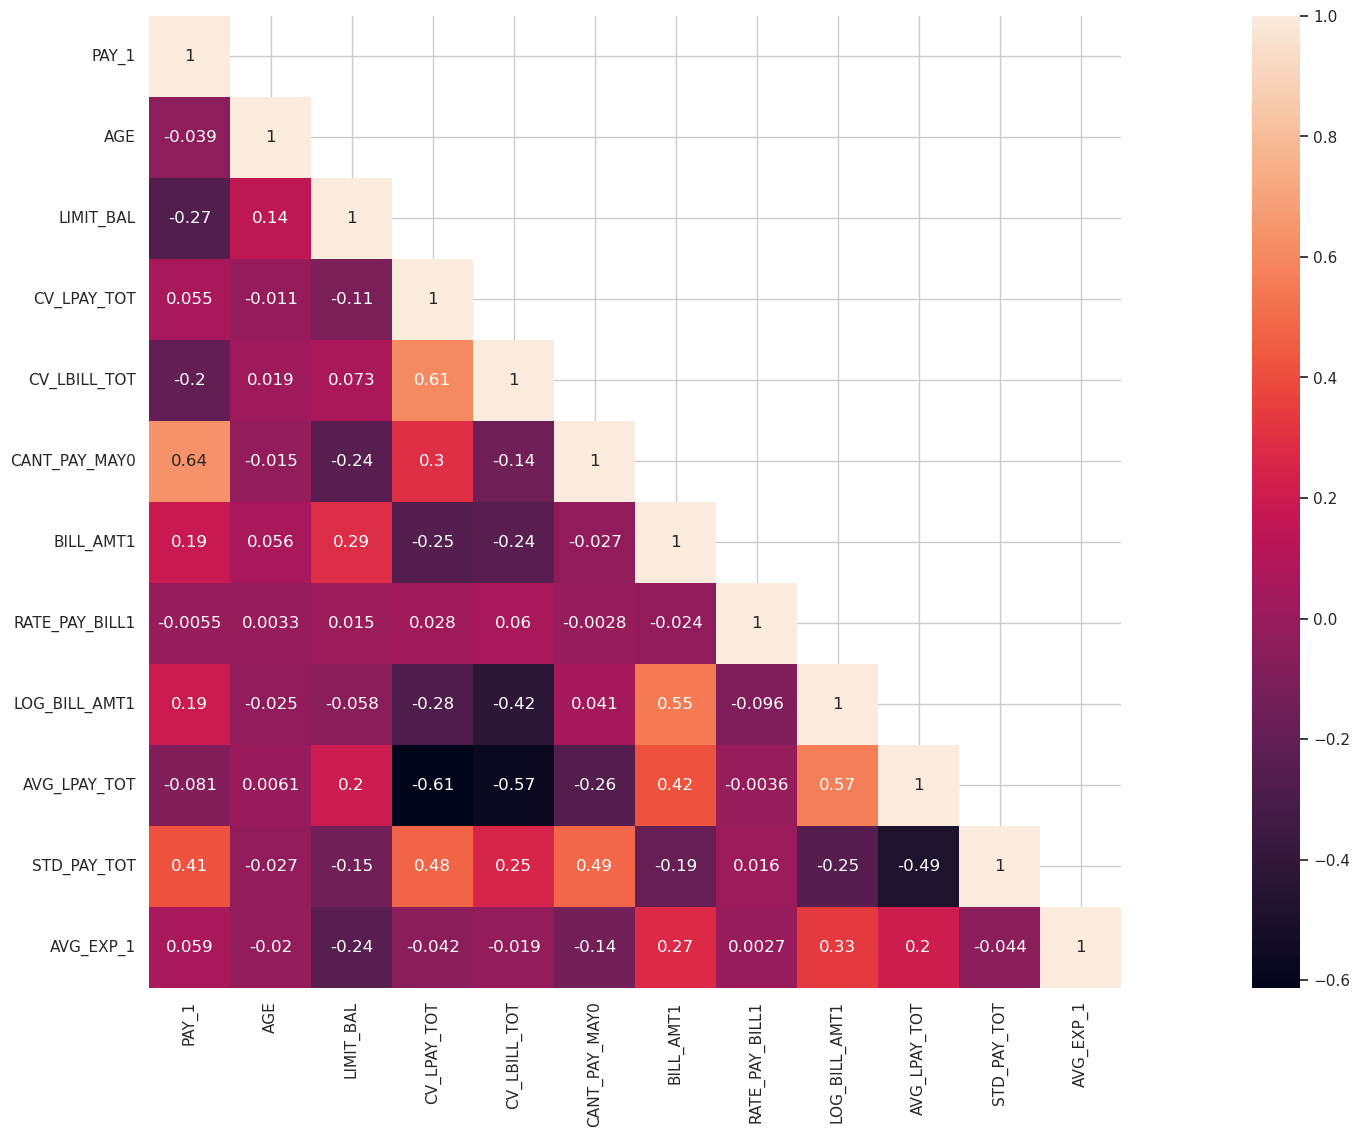

In [71]:
## Matriz de corelaciones
cor_mat = df[['PAY_1','AGE','LIMIT_BAL','CV_LPAY_TOT','CV_LBILL_TOT','CANT_PAY_MAY0','BILL_AMT1','RATE_PAY_BILL1','LOG_BILL_AMT1','AVG_LPAY_TOT','STD_PAY_TOT','AVG_EXP_1']].corr()
mask = np.array(cor_mat)
mask[np.tril_indices_from(mask)] = False
fig = plt.gcf()
fig.set_size_inches(30,12)
sns.heatmap(data=cor_mat,mask=mask,square=True,annot=True,cbar=True)

In [72]:
# Regresion Logistica Con Selección de Variables
import statsmodels.api as sm
logit_model=sm.Logit(df.DEFAULT,df[['SEX','PAY_1','LIMIT_BAL','CV_LPAY_TOT','CV_LBILL_TOT','CANT_PAY_MAY0','BILL_AMT1','AVG_LPAY_TOT','STD_PAY_TOT','AVG_EXP_1']])
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.447224
         Iterations 6
                         Results: Logit
Model:              Logit            Method:           MLE       
Dependent Variable: DEFAULT          Pseudo R-squared: 0.154     
Date:               2024-05-29 00:45 AIC:              26853.4297
No. Observations:   30000            BIC:              26936.5192
Df Model:           9                Log-Likelihood:   -13417.   
Df Residuals:       29990            LL-Null:          -15853.   
Converged:          1.0000           LLR p-value:      0.0000    
No. Iterations:     6.0000           Scale:            1.0000    
-----------------------------------------------------------------
                  Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
-----------------------------------------------------------------
SEX              -0.1633   0.0303  -5.3930 0.0000 -0.2226 -0.1039
PAY_1             0.2825   0.0194  14.5472 0.0000  0.2444  0.3206


### **5. Modelamiento de Datos o Creación del Algoritmo de ML**

#### 5.1. Particion Muestral

Seleccionamos las variables más importantes

In [73]:
data = df[['SEX','PAY_1','AGE','LIMIT_BAL','CV_LPAY_TOT','CV_LBILL_TOT','CANT_PAY_MAY0','BILL_AMT1','LOG_BILL_AMT1','AVG_LPAY_TOT','STD_PAY_TOT','AVG_EXP_1','DEFAULT']].sample(frac=0.9, random_state=1000)
data_unseen = df[['SEX','PAY_1','AGE','LIMIT_BAL','CV_LPAY_TOT','CV_LBILL_TOT','CANT_PAY_MAY0','BILL_AMT1','LOG_BILL_AMT1','AVG_LPAY_TOT','STD_PAY_TOT','AVG_EXP_1','DEFAULT']].drop(data.index)
data.reset_index(inplace=True, drop=True)
data_unseen.reset_index(inplace=True, drop=True)
print('Data for Modeling: ' + str(data.shape))
print('Unseen Data For Predictions: ' + str(data_unseen.shape))

Data for Modeling: (27000, 13)
Unseen Data For Predictions: (3000, 13)


In [74]:
# Creación de los datos de train y test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data.drop(['DEFAULT'],axis=1),
                                                   data.DEFAULT,
                                                   test_size=0.333,
                                                   random_state=12345) 

In [75]:
X_train.head()

,SEX,PAY_1,AGE,LIMIT_BAL,CV_LPAY_TOT,CV_LBILL_TOT,CANT_PAY_MAY0,BILL_AMT1,LOG_BILL_AMT1,AVG_LPAY_TOT,STD_PAY_TOT,AVG_EXP_1
20323,0,2,31,30000,0.830531,0.624768,1,390,5.96871,3.099667,1.224745,0.013000
6226,0,0,55,80000,0.142548,0.077772,0,82567,11.32138,7.202175,0.000000,0.205187
23653,0,-2,27,360000,0.876552,0.656303,0,2807,7.94023,3.789672,0.000000,0.006153
4870,1,2,24,140000,0.426373,0.002635,6,50643,10.83258,6.554537,0.000000,0.009209
5766,0,-1,54,500000,0.220029,0.071429,1,10287,9.23873,7.681080,1.224745,0.008853


#### 5.2. Algoritmos Machine Learning

### Regresion Logistica Binaria

In [76]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()

In [77]:
lr.fit(X_train,y_train) # Entrenamiento!

LogisticRegression()

In [78]:
# Con el algoritmo entrenado predecimos sobre la data de train y test!

y_pred_train=lr.predict(X_train) # Prediccion sobre train
y_pred_test= lr.predict(X_test) # Prediccion sobre test

In [79]:
## Metricas de validación
def calc_metrics(y_train,y_pred_train,y_test,y_pred_test):
    
    # Matriz de confusion
    print("Matriz confusion: Train")
    cm_train = confusion_matrix(y_train,y_pred_train)
    print(cm_train)

    print("Matriz confusion: Test")
    cm_test = confusion_matrix(y_test,y_pred_test)
    print(cm_test)

    # Accuracy
    print("Accuracy: Train")
    accuracy_train=accuracy_score(y_train,y_pred_train)
    print(accuracy_train)

    print("Accuracy: Test")
    accuracy_test=accuracy_score(y_test,y_pred_test)
    print(accuracy_test)

    # Precision o Aporte del Modelo
    print("Precision: Train")
    precision_train=precision_score(y_train,y_pred_train)
    print(precision_train)

    print("Precision: Test")
    precision_test=precision_score(y_test,y_pred_test)
    print(precision_test)

    # Recall o Sensibilidad 
    print("Recall: Train")
    recall_train=recall_score(y_train,y_pred_train)
    print(recall_train)

    print("Recall: Test")
    recall_test=recall_score(y_test,y_pred_test)
    print(recall_test)

In [80]:
calc_metrics(y_train,y_pred_train,y_test,y_pred_test)

Matriz confusion: Train
[[13983     0]
 [ 4026     0]]
Matriz confusion: Test
[[7051    0]
 [1940    0]]
Accuracy: Train
0.7764451107779443
Accuracy: Test
0.7842286731175621
Precision: Train
0.0
Precision: Test
0.0
Recall: Train
0.0
Recall: Test
0.0


In [81]:
ind = pd.DataFrame(columns = ['Modelo', 'F1Score'])

In [84]:
f1score=f1_score(y_test,y_pred_test)
#ind = ind.append({'Modelo' : 'LogReg', 'F1Score' : f1score}, ignore_index = True)
ind = pd.concat([ind, {'Modelo' : 'LogReg', 'F1Score' : f1score}])
ind

TypeError: cannot concatenate object of type '<class 'dict'>'; only Series and DataFrame objs are valid

In [ ]:
y_prob = lr.predict_proba(X_test)
kds.metrics.report(y_test, y_prob[:,1],plot_style='ggplot')

In [ ]:
# Juntamos el ID con la clase
data = np.hstack((X_test['BILL_AMT1'].values.reshape(-1,1), y_prob[:,1].reshape(-1,1)))
df_submmit = pd.DataFrame(data, columns=['Real','Proba'])
df_submmit.to_csv('test_01_lr.csv', index=False)

### Arbol de Clasificacion CART

In [ ]:
from sklearn.tree import DecisionTreeClassifier
tree_expert = DecisionTreeClassifier(
                       class_weight=None, 
                       criterion='gini',
                       max_depth=5,   
                       max_features=7,     
                       max_leaf_nodes=None, 
                       min_samples_leaf=5, 
                       min_samples_split=5,
                       min_weight_fraction_leaf=0.01, 
                       random_state=1000, 
                       splitter='best')

In [ ]:
# Entrenamos!
tree_expert = tree_expert.fit(X_train,y_train) # ajustando el modelo a mis datos

In [ ]:
# Predecimos!
y_pred_train = tree_expert.predict(X_train) # realizando la predicción sobre Train
y_pred_test  = tree_expert.predict(X_test) # realizando la predicción sobre Test

In [ ]:
calc_metrics(y_train,y_pred_train,y_test,y_pred_test)

In [ ]:
f1score=f1_score(y_test,y_pred_test)
ind = ind.append({'Modelo' : 'DecisionTree', 'F1Score' : f1score}, ignore_index = True)
ind

In [ ]:
y_prob = tree_expert.predict_proba(X_test)
kds.metrics.report(y_test, y_prob[:,1],plot_style='ggplot')

In [ ]:
# Juntamos el ID con la clase
data = np.hstack((X_test['BILL_AMT1'].values.reshape(-1,1), y_prob[:,1].reshape(-1,1)))
df_submmit = pd.DataFrame(data, columns=['Monto','P_Aproba'])
df_submmit.to_csv('test_02_tree.csv', index=False)

### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=150,
                            max_features= 7,
                            max_depth=5
                            ) # Numero de obs por nodo hoja
rf.fit(X_train, y_train) # Entrenando un algoritmo

In [ ]:
# Predecir con el algoritmo entrenado para validar
y_pred_train=rf.predict(X_train) # Prediccion sobre train
y_pred_test= rf.predict(X_test) # Prediccion sobre test

In [ ]:
calc_metrics(y_train,y_pred_train,y_test,y_pred_test)

In [ ]:
f1score=f1_score(y_test,y_pred_test)
ind = ind.append({'Modelo' : 'RandomForest', 'F1Score' : f1score}, ignore_index = True)
ind

In [ ]:
y_prob = rf.predict_proba(X_test)
kds.metrics.report(y_test, y_prob[:,1],plot_style='ggplot')

In [ ]:
# Juntamos el ID con la clase
data = np.hstack((X_test['BILL_AMT1'].values.reshape(-1,1), y_prob[:,1].reshape(-1,1)))
df_submmit = pd.DataFrame(data, columns=['Monto','P_Aproba'])
df_submmit.to_csv('test_03_rf.csv', index=False)

### XGBoost

In [ ]:
import xgboost as xgb
xgb_mod=xgb.XGBClassifier(max_depth=2, n_estimators=50, objective='binary:logistic', seed=0, silent=True, subsample=.8)
xgb_mod.fit(X_train, y_train)

In [ ]:
# Predecir con el algoritmo entrenado para validar
y_pred_train=xgb_mod.predict(X_train) # Prediccion sobre train
y_pred_test= xgb_mod.predict(X_test) # Prediccion sobre test

In [ ]:
calc_metrics(y_train,y_pred_train,y_test,y_pred_test)

In [ ]:
f1score=f1_score(y_test,y_pred_test)
ind = ind.append({'Modelo' : 'XGBoost', 'F1Score' : f1score}, ignore_index = True)
ind

In [ ]:
kds.metrics.report(y_test, y_pred_test,plot_style='ggplot')

In [ ]:
# Juntamos el ID con la clase
data = np.hstack((X_test['BILL_AMT1'].values.reshape(-1,1), y_pred_test.reshape(-1,1)))
df_submmit = pd.DataFrame(data, columns=['Monto','P_Aproba'])
df_submmit.to_csv('test_04_xgb.csv', index=False)

### Grid Search de Parámetros

In [ ]:
# Definimos la funcion de GridSearch
from sklearn.model_selection import GridSearchCV         # Busqueda exhaustiva de la mejor combinacion
from sklearn.model_selection import RandomizedSearchCV   # Busqueda aleatoria de la mejor combinacion
from scipy.stats import randint as sp_randint

In [ ]:
# Configuramos el subset de parametros a trabajar
cv_params = {'max_depth': [2,3,4],
            'subsample':[0.7,0.8,0.9],
             'n_estimators':[50,100,200]}

In [ ]:
# Definimos un clasificador inicial, generalmente sin muchos parametros
xgboost_t=xgb.XGBClassifier().fit(X_train, y_train)

In [ ]:
# Con el clasificador inicial, tratamos de buscar los mejores parametros
optimized_GBM = RandomizedSearchCV(xgboost_t, cv_params, scoring = 'accuracy', cv = 5) 

In [ ]:
# Buscamos los parametros de acuerdo a nuestro criterio
opGBM=optimized_GBM.fit(X_train, y_train)

In [ ]:
# De acuerdo a la busqueda , nos quedamos con los mejores parametros 
print (optimized_GBM.best_params_)

In [ ]:
# Predecimos con el algoritmo entrenado sobre el test y evaluamos
y_pred_train=opGBM.predict(X_train)
y_pred_test=opGBM.predict(X_test)

In [ ]:
calc_metrics(y_train,y_pred_train,y_test,y_pred_test)

In [ ]:
f1score=f1_score(y_test,y_pred_test)
ind = ind.append({'Modelo' : 'GridSearch', 'F1Score' : f1score}, ignore_index = True)
ind

In [ ]:
y_prob = opGBM.predict_proba(X_test)
kds.metrics.report(y_test, y_prob[:,1],plot_style='ggplot')

In [ ]:
# Juntamos el ID con la clase
data = np.hstack((X_test['BILL_AMT1'].values.reshape(-1,1), y_prob[:,1].reshape(-1,1)))
df_submmit = pd.DataFrame(data, columns=['Monto','P_Aproba'])
df_submmit.to_csv('test_05_opxgb.csv', index=False)

### 6. Evaluación de Modelos

In [ ]:
# Guardamos el mejor modelo entrenado para usarlo en la implementación
import pickle
filename = 'bestmodel.pkl'
pickle.dump(opGBM, open(filename, 'wb'))

### 7. Scoring del Modelo

In [ ]:
# Todo lo realizado en el dataset de entrenamiento del modelo lo debemos replicar en el dataset de scoring

In [ ]:
data_unseen.shape

In [ ]:
data_unseen.head()

In [ ]:
# Una vez que tenemos todas las variables podemos scorear o puntuar los registros

# Leemos el modelo entrenado!
import pickle
filename = 'bestmodel.pkl'
mod_seg = pickle.load(open(filename, 'rb'))

In [ ]:
# Predecimos sobre el set de datos de implementacion con el modelo entrenado
score_final=mod_seg.predict(data_unseen.drop(['DEFAULT'],axis=1)) 

In [ ]:
score_final.size

In [ ]:
# Juntamos el ID con la clase
data = np.hstack((data_unseen['DEFAULT'].values.reshape(-1,1), score_final.reshape(-1,1)))
# Le asignamos nombres a las columnas
df_submmit = pd.DataFrame(data, columns=['DEFAULT','Prob'])
# Exportamos la solucion
df_submmit.to_csv('valida_scoring.csv', index=False)